In [74]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

plt.style.use("/home/pepijn/Documents/uni/y5/thesis/writing/msc-thesis-figures/std-colors.mplstyle")

df = pd.read_parquet('../../../amalur-factorization/profiling/all_1repeat_operators_cleaned.parquet')
df.head()

,id,kernel_name,compute_throughput,dram_frequency,dram_throughput,duration,elapsed_cycles,l1_throughput,l1_hit_rate,l2_throughput,...,dram_bytes_read,dram_bytes_write,filename,gpu,experiment,block_size,grid_size,type,operator,dataset
0,0,cupy_copy__int64_int64,0.00,3.786260e+09,0.01,4192.0,3338.0,48.45,0.0,0.31,...,128.0,0.0,--mnt--data--1M--n_R=1-r_T=1000000-c_T=30-rho_...,a10g,all_1repeat_operators,"(2, 1, 1)","(1, 1, 1)",factorized,LMM,--mnt--data--1M--n_R=1-r_T=1000000-c_T=30-rho_...
1,1,void cub::DeviceScanInitKernel<cub::ScanTileSt...,0.01,4.186667e+09,0.01,3200.0,2832.0,76.68,0.0,0.37,...,128.0,0.0,--mnt--data--1M--n_R=1-r_T=1000000-c_T=30-rho_...,a10g,all_1repeat_operators,"(128, 1, 1)","(1, 1, 1)",factorized,LMM,--mnt--data--1M--n_R=1-r_T=1000000-c_T=30-rho_...
2,2,void cub::DeviceScanKernel<cub::DeviceScanPoli...,0.14,4.026144e+09,0.01,4896.0,4210.0,30.61,1.0,0.78,...,128.0,0.0,--mnt--data--1M--n_R=1-r_T=1000000-c_T=30-rho_...,a10g,all_1repeat_operators,"(128, 1, 1)","(1, 1, 1)",factorized,LMM,--mnt--data--1M--n_R=1-r_T=1000000-c_T=30-rho_...
3,3,void cusparse::<unnamed>::binary_search_partit...,0.16,5.339790e+09,7.30,13216.0,14889.0,7.74,1.0,1.35,...,494592.0,0.0,--mnt--data--1M--n_R=1-r_T=1000000-c_T=30-rho_...,a10g,all_1repeat_operators,"(128, 1, 1)","(8, 1, 1)",factorized,LMM,--mnt--data--1M--n_R=1-r_T=1000000-c_T=30-rho_...
4,4,void cusparse::<unnamed>::binary_search_lb_ker...,11.92,5.381468e+09,78.83,53184.0,60297.0,18.30,1.0,33.93,...,15289472.0,6371200.0,--mnt--data--1M--n_R=1-r_T=1000000-c_T=30-rho_...,a10g,all_1repeat_operators,"(128, 1, 1)","(977, 1, 1)",factorized,LMM,--mnt--data--1M--n_R=1-r_T=1000000-c_T=30-rho_...


In [75]:
import numpy as np
units = {
    "compute_throughput": "percent",
    "dram_frequency": "cycle/second",
    "dram_throughput": "percent",
    "duration": "nsecond",
    "elapsed_cycles": "cycle",
    "l1_throughput": "percent",
    "l1_hit_rate": "percent",
    "l2_throughput": "percent",
    "l2_hit_rate": "percent",
    "max_bandwidth": "percent",
    "mem_busy": "percent",
    "mem_pipes_busy": "percent",
    "memory_throughput": "percent",
    "memory_throughput_byte": "byte/second",    
    "sm_active_cycles": "cycle",
    "sm_frequency": "cycle/second",
    "dram_bytes_read": "byte",
    "dram_bytes_write": "byte",
}

def weighted_mean(values, weights):
    return np.sum(weights * values) / np.sum(weights)

def sum(values, *args):
    return np.sum(values)

def mean(values, *args):
    return np.mean(values)

def none(x, *args):
    return None

agg_functions = {
    "percent": weighted_mean,
    "nsecond": sum,
    "cycle": sum,
    "byte": sum,
    "cycle/second": weighted_mean,
    "byte/second": weighted_mean
}

def aggregate(df):
    res = {}
    for col, unit in units.items():
        func = agg_functions.get(unit, none)
        res[f"{col}_{func.__name__}"] = func(df[col], df['duration'])
    return pd.Series(res)
aggregated_df = df.groupby(['operator', 'type', 'gpu', 'dataset']).apply(aggregate)

/tmp/ipykernel_65496/4027174590.py:50: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  aggregated_df = df.groupby(['operator', 'type', 'gpu', 'dataset']).apply(aggregate)


In [76]:
import json
with open ("/home/pepijn/Documents/uni/y5/thesis/amalur/amalur-experiments/results/full_1/daic/features/gpu-characteristics.json") as f:
    gpu_chars = json.load(f)
gpu_chars['1080'] = gpu_chars.pop('1080Ti')
gpu_chars['p100'] = gpu_chars.pop('P100')
gpu_chars['v100'] = gpu_chars.pop('V100')
gpu_chars['2080'] = gpu_chars.pop('2080Ti')
gpu_chars['a40'] = gpu_chars.pop('A40')
gpu_chars['a10g'] = gpu_chars.pop('A10G')
gpu_chars['1660'] = gpu_chars.pop('1660Ti')
gpu_chars_df = pd.DataFrame(gpu_chars).T.apply(pd.to_numeric, errors='ignore')
gpu_chars_df.rename(columns={x: f"gpu_{x}" for x in gpu_chars_df.columns}, inplace=True)
gpu_chars_df


/tmp/ipykernel_65496/2625815541.py:11: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  gpu_chars_df = pd.DataFrame(gpu_chars).T.apply(pd.to_numeric, errors='ignore')


,gpu__architecture,gpu__number_of_sm,gpu__cores,gpu_cache_size_l1,gpu_cache_size_l2,gpu_clock_speed_base,gpu_clock_speed_max_boost,gpu_memory_bus_width,gpu_memory_size,gpu_memory_clock,gpu_memory_bandwidth,gpu_processing_power_half_precision,gpu_processing_power_single_precision,gpu_processing_power_double_precision
1080,Pascal,28,3584,48,2.8,1480,1582,352,11,11000,484,0.17,10.61,0.3315
p100,Pascal,56,3584,24,4.0,1126,1303,4096,16,1430,732,21.20,10.60,5.3000
v100,Volta,80,5120,128,6.2,1230,1370,4096,32,1750,900,112.22,14.03,7.0140
2080,Turing,68,4352,64,5.5,1350,1545,352,11,14000,616,23.50,11.75,0.3168
a40,Ampere,84,10752,128,6.0,1305,1740,384,48,7248,696,149.68,37.42,0.5846
a10g,Ampere,72,9216,128,6.0,1320,1710,384,24,6252,600,31.52,31.52,0.9850
1660,Turing,24,1536,64,1.5,1500,1770,192,6,12000,288,9.22,4.61,0.1440


In [77]:
with_gpu_chars = aggregated_df.reset_index().merge(gpu_chars_df, left_on='gpu', right_index=True)
with_gpu_chars.describe()

,compute_throughput_weighted_mean,dram_frequency_weighted_mean,dram_throughput_weighted_mean,duration_sum,elapsed_cycles_sum,l1_throughput_weighted_mean,l1_hit_rate_weighted_mean,l2_throughput_weighted_mean,l2_hit_rate_weighted_mean,max_bandwidth_weighted_mean,...,gpu_cache_size_l2,gpu_clock_speed_base,gpu_clock_speed_max_boost,gpu_memory_bus_width,gpu_memory_size,gpu_memory_clock,gpu_memory_bandwidth,gpu_processing_power_half_precision,gpu_processing_power_single_precision,gpu_processing_power_double_precision
count,3325.000000,3.325000e+03,3325.000000,3.325000e+03,3.325000e+03,3325.000000,3325.000000,3325.000000,3325.000000,3325.000000,...,3325.000000,3325.000000,3325.000000,3325.000000,3325.000000,3325.000000,3325.000000,3325.000000,3325.000000,3325.000000
mean,14.641988,6.166919e+09,49.870619,6.589266e+07,9.046961e+07,24.723216,0.792557,25.147054,0.998170,52.057471,...,4.616842,1370.133835,1738.827068,324.985263,26.775338,8363.534436,537.332932,65.568589,25.291092,0.587899
std,12.007644,7.445471e+08,32.645978,1.241962e+08,1.745653e+08,13.090989,0.245024,15.325347,0.002930,33.249635,...,2.076627,86.749559,24.233282,88.602773,17.069381,2458.036057,170.857690,61.869082,13.996067,0.339468
min,0.187153,4.516258e+09,0.187558,4.041600e+04,4.992300e+04,1.183345,0.162334,0.117662,0.988710,0.352169,...,1.500000,1305.000000,1710.000000,192.000000,6.000000,6252.000000,288.000000,9.220000,4.610000,0.144000
25%,6.346482,5.640872e+09,11.968378,1.249120e+06,1.706370e+06,17.420489,0.742629,8.203190,0.997149,13.472628,...,1.500000,1305.000000,1710.000000,192.000000,6.000000,6252.000000,288.000000,9.220000,4.610000,0.144000
50%,14.613694,6.121370e+09,59.942321,6.973952e+06,8.782419e+06,25.050272,0.901870,29.999453,1.000000,65.012265,...,6.000000,1320.000000,1740.000000,384.000000,24.000000,7248.000000,600.000000,31.520000,31.520000,0.584600
75%,17.703415,6.746321e+09,82.593110,7.083533e+07,9.156360e+07,32.549017,0.967614,38.662071,1.000000,84.494477,...,6.000000,1500.000000,1770.000000,384.000000,48.000000,12000.000000,696.000000,149.680000,37.420000,0.985000
max,81.060451,9.474108e+09,91.209112,7.227483e+08,1.090849e+09,79.766301,0.999598,47.969233,1.000000,91.235039,...,6.000000,1500.000000,1770.000000,384.000000,48.000000,12000.000000,696.000000,149.680000,37.420000,0.985000


In [78]:
sets = {}
for name, group in with_gpu_chars.groupby(['type', 'gpu']):
    sets[name] = set(group[['operator', 'dataset']].drop_duplicates().apply(tuple, axis=1))
keep_set = set.intersection(*sets.values())
len(keep_set)
with_gpu_chars = with_gpu_chars[with_gpu_chars[['operator', 'dataset']].apply(tuple, axis=1).isin(keep_set)]

In [79]:
with_gpu_chars[[x for x in with_gpu_chars.columns if 'l1' in x or 'l2' in x or 'dram' in x]]

,dram_frequency_weighted_mean,dram_throughput_weighted_mean,l1_throughput_weighted_mean,l1_hit_rate_weighted_mean,l2_throughput_weighted_mean,l2_hit_rate_weighted_mean,dram_bytes_read_sum,dram_bytes_write_sum,gpu_cache_size_l1,gpu_cache_size_l2
0,5.585885e+09,6.732479,5.541501,0.976926,7.548491,1.000000,8.365440e+06,4.146880e+05,64,1.5
1,5.640872e+09,7.149560,5.925364,0.973708,7.923254,1.000000,7.561504e+06,3.811520e+05,64,1.5
2,5.668171e+09,4.906661,6.361888,0.981563,5.559798,1.000000,8.498912e+06,3.016640e+05,64,1.5
3,5.666172e+09,6.718101,5.670674,0.976662,7.601705,1.000000,8.561120e+06,4.009280e+05,64,1.5
4,5.623562e+09,5.535707,6.357983,0.980032,6.276584,1.000000,8.195616e+06,2.589760e+05,64,1.5
...,...,...,...,...,...,...,...,...,...,...
3320,7.776221e+09,9.434067,26.856021,0.926148,6.982541,1.000000,1.154509e+08,3.584000e+03,128,6.0
3321,6.748394e+09,9.665799,26.742579,0.926008,7.227809,1.000000,1.154484e+08,2.816000e+03,128,6.0
3322,5.963211e+09,58.677727,35.010319,0.942614,36.332214,1.000000,1.225429e+09,5.688818e+08,128,6.0
3323,7.096939e+09,83.946295,29.252095,0.682232,42.132908,0.994407,1.903227e+10,1.580797e+10,128,6.0


In [80]:
# math cost = sm_active_cycles / sm frequency
with_gpu_chars['math_cost_seconds'] = with_gpu_chars['sm_active_cycles_sum'] / with_gpu_chars['sm_frequency_weighted_mean']
with_gpu_chars['dram_bytes_sum'] = (with_gpu_chars['dram_bytes_read_sum'] + with_gpu_chars['dram_bytes_write_sum'])
with_gpu_chars['mem_cost_seconds'] = with_gpu_chars['dram_bytes_sum'] / with_gpu_chars['memory_throughput_byte_weighted_mean']
# Throughput as percentage of max / 100 = throughput as fraction. Multiply by max bandwidth to achieved bytes per second
with_gpu_chars['ops_per_second'] = ((with_gpu_chars['compute_throughput_weighted_mean'] / 100) * (with_gpu_chars['gpu_processing_power_double_precision'] * 1e12))
# Ops/s * duration = ops, ops / dram bytes = arithmetic intensity
with_gpu_chars['arithmetic_intensity'] = ((with_gpu_chars['ops_per_second'] * (with_gpu_chars.duration_sum / 1e9)) / (with_gpu_chars['dram_bytes_sum'] ))
with_gpu_chars["gflops_per_second"] = with_gpu_chars["ops_per_second"] / 1e9
with_gpu_chars[['math_cost_seconds', 'mem_cost_seconds', 'dram_bytes_sum', 'arithmetic_intensity', 'ops_per_second']].describe()

with_gpu_chars.to_parquet("../daic/profiling/aggregated.parquet")

In [81]:
(with_gpu_chars.math_cost_seconds / with_gpu_chars.mem_cost_seconds).describe()

count    2862.000000
mean        0.716244
std         0.296714
min         0.016198
25%         0.513237
50%         0.838169
75%         0.968728
max         1.001116
dtype: float64

In [82]:
# looks like mem_cost_seconds is a perfect approximation of duration_sum, so probably wrong calc...
(max(with_gpu_chars.mem_cost_seconds, ) / (with_gpu_chars.duration_sum / 1e9)).describe()

count     2862.000000
mean      1491.701823
std       3688.299814
min          1.000000
25%         11.809124
50%        116.879674
75%        674.124021
max      17787.826603
Name: duration_sum, dtype: float64

In [83]:
pd.Series(np.maximum(with_gpu_chars.math_cost_seconds, with_gpu_chars.mem_cost_seconds)/ (with_gpu_chars.duration_sum / 1e9)).describe()

count    2862.000000
mean        1.000001
std         0.000023
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max         1.001116
dtype: float64

In [84]:
# # ax = sns.scatterplot(data=with_gpu_chars, x='math_cost_seconds', y='duration_sum', hue='gpu')
# ax = sns.kdeplot(with_gpu_chars.mem_cost_seconds  (with_gpu_chars.duration_sum / 1e9))
# # ax.set_xlim(0.9999999999994123, 1.000000000000605)
# ax.get_xlim()

In [85]:
with_gpu_chars[(with_gpu_chars.mem_cost_seconds < with_gpu_chars.math_cost_seconds)]

,operator,type,gpu,dataset,compute_throughput_weighted_mean,dram_frequency_weighted_mean,dram_throughput_weighted_mean,duration_sum,elapsed_cycles_sum,l1_throughput_weighted_mean,...,gpu_memory_bandwidth,gpu_processing_power_half_precision,gpu_processing_power_single_precision,gpu_processing_power_double_precision,math_cost_seconds,dram_bytes_sum,mem_cost_seconds,ops_per_second,arithmetic_intensity,gflops_per_second
584,LMM,factorized,1660,--mnt--data--1M--n_R=1-r_T=1000000-c_T=40-rho_...,79.717999,5.968769e+09,12.670825,23252768.0,35067366.0,29.950645,...,288,9.22,4.61,0.144,0.023265,8.322212e+08,0.023253,1.147939e+11,3.207412,114.793918
1822,RMM,materialized,1660,--mnt--data--1M--n_R=1-r_T=1000000-c_T=20-rho_...,15.405249,5.726367e+09,80.044852,271364704.0,408065788.0,41.309924,...,288,9.22,4.61,0.144,0.271668,5.974991e+10,0.271365,2.218356e+10,0.100751,22.183559


(1, 10000.0)

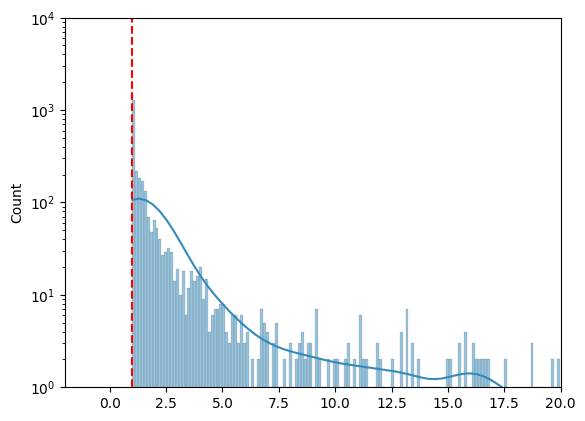

In [86]:
# ax = sns.scatterplot(data=with_gpu_chars, x='math_cost_seconds', y='duration_sum', hue='gpu')
ax = sns.histplot(with_gpu_chars.mem_cost_seconds / with_gpu_chars.math_cost_seconds, kde=True)
ax.set_xlim(-2, 20)
ax.axvline(1.0, color='red', linestyle='--')
ax.set_yscale('log')
ax.set_ylim(1, 1e4)

(1.9952623149688787e-06, 3.1622776601683795)

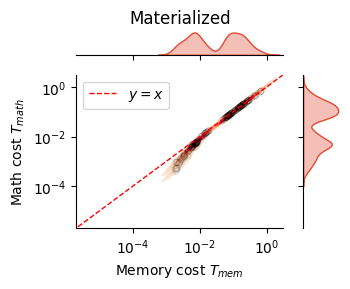

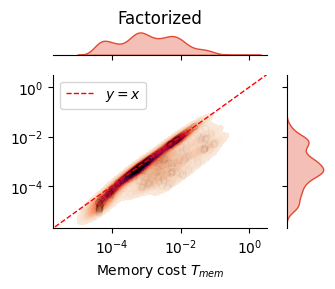

In [87]:

def kde_plot(tdf,i):
    grid=sns.jointplot(data=tdf, x='mem_cost_seconds', y='math_cost_seconds',
                kind='kde',log_scale=True, fill=True, levels=100,thresh=0.01,
                height=3.4, ratio=4, space=0.1,
                cmap="rocket_r", marginal_kws=dict(color=sns.color_palette()[1], alpha=0.35),
    #                     #  hue='operator'
                        )
    grid.figure.set_figwidth(8*0.45 - (i*0.15))
    grid.figure.set_figheight(3)
    ax=grid.ax_joint
    ax.scatter(tdf.mem_cost_seconds, tdf.math_cost_seconds, s=20, facecolors='none', edgecolors='black', linewidths=0.5, alpha=0.02)
    range = [10**-6, 10**0.5]
    sns.lineplot(x=range, y=range, color='red', linestyle='--', linewidth=1, ax=ax, label='$y=x$')
    ax.set_xlabel(r'Memory cost $T_{mem}$')
    ax.set_ylabel(r'Math cost $T_{math}$')
    ax.legend()
    return ax, grid
ax1, grid1 = kde_plot(with_gpu_chars[with_gpu_chars.type == 'materialized'].copy(), i=0)
grid1.ax_marg_x.set_title("Materialized")
ax2, grid2 = kde_plot(with_gpu_chars[with_gpu_chars.type == 'factorized'].copy(), i=1)
grid2.ax_marg_x.set_title("Factorized")
ax2.set_ylabel(None)
ax1.sharey(ax2)
ax1.sharex(ax2)
grid1.figure.tight_layout()
grid2.figure.tight_layout()
ax1.set_xlim(10**-5.7, 10**0.5)
ax1.set_ylim(10**-5.7, 10**0.5)
# grid1.savefig("/home/pepijn/Documents/uni/y5/thesis/writing/overleaf/chapters/05_cost_estimation/figures/profiling-mem-vs-compute-materialized.pdf")
# grid2.savefig("/home/pepijn/Documents/uni/y5/thesis/writing/overleaf/chapters/05_cost_estimation/figures/profiling-mem-vs-compute-factorized.pdf")


In [88]:
with_gpu_chars[['math_cost_seconds', 'mem_cost_seconds', 'type']].groupby('type').corr()

math_cost_seconds  mem_cost_seconds
type                                                               
factorized   math_cost_seconds           1.000000          0.351531
             mem_cost_seconds            0.351531          1.000000
materialized math_cost_seconds           1.000000          0.999871
             mem_cost_seconds            0.999871          1.000000

In [89]:
with_gpu_chars[['math_cost_seconds', 'mem_cost_seconds', 'type', 'dram_throughput_weighted_mean', 'compute_throughput_weighted_mean']].groupby('type').mean()

,math_cost_seconds,mem_cost_seconds,dram_throughput_weighted_mean,compute_throughput_weighted_mean
type,,,,
factorized,0.002356,0.006552,29.030188,12.967090
materialized,0.093501,0.096003,67.064617,15.488373


/tmp/ipykernel_65496/160464192.py:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


[Text(0, 0, 'Columnsummation'),
 Text(1, 0, 'ColumnsummationT'),
 Text(2, 0, 'LMM'),
 Text(3, 0, 'LMMT'),
 Text(4, 0, 'Leftmultiply'),
 Text(5, 0, 'LeftmultiplyT'),
 Text(6, 0, 'RMM'),
 Text(7, 0, 'RMMT'),
 Text(8, 0, 'Rightmultiply'),
 Text(9, 0, 'RightmultiplyT'),
 Text(10, 0, 'Rowsummation'),
 Text(11, 0, 'RowsummationT')]

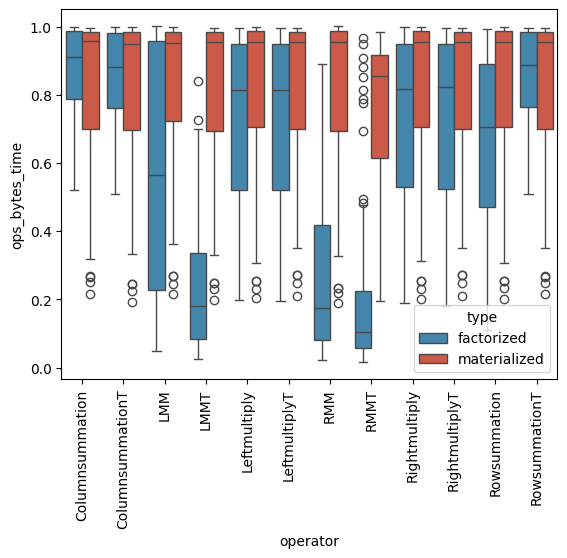

In [90]:
with_gpu_chars['ops_bytes_time'] = with_gpu_chars['math_cost_seconds']/ with_gpu_chars['mem_cost_seconds']
ax = sns.boxplot(data=with_gpu_chars, y='ops_bytes_time', x='operator', hue='type')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

# ax.set_yscale('log')
# ax.set_xscale('log')


## Attempt at Roofline chart

In [91]:
with_gpu_chars[['sm_frequency_weighted_mean', 'dram_bytes_read_sum', 'sm_active_cycles_sum', 'arithmetic_intensity']].describe()

,sm_frequency_weighted_mean,dram_bytes_read_sum,sm_active_cycles_sum,arithmetic_intensity
count,2.862000e+03,2.862000e+03,2.862000e+03,2862.000000
mean,1.309900e+09,1.076490e+10,6.738403e+07,0.468354
std,1.194740e+08,2.183677e+10,1.522895e+08,0.631324
min,9.973247e+08,1.978624e+06,1.293916e+04,0.093491
25%,1.222018e+09,6.628159e+07,6.227286e+05,0.175030
50%,1.297222e+09,4.499636e+08,4.486131e+06,0.298883
75%,1.410508e+09,1.498742e+10,6.800475e+07,0.482287
max,1.704576e+09,1.059329e+11,1.080764e+09,7.186743


<Axes: xlabel='ops_per_second', ylabel='Count'>

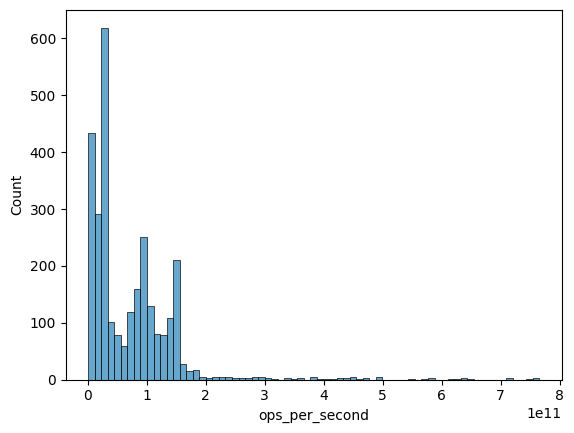

In [92]:
sns.histplot(with_gpu_chars['ops_per_second'])

In [93]:
with_gpu_chars.groupby(["type", "dataset", "operator"]).dram_bytes_sum.std()

type          dataset                                                                                                                                        operator        
factorized    --mnt--data--100k--n_R=1-r_T=100000-c_T=10-rho_c_S=0.1-rho_c_R=0.1-p=0.0-join=inner--ratio_9.5--data--_preset                                  Columnsummation     8.036532e+05
                                                                                                                                                             ColumnsummationT    8.979053e+05
                                                                                                                                                             LMM                 2.600265e+06
                                                                                                                                                             LMMT                6.557867e+05
                                                                  

In [94]:
min(with_gpu_chars['arithmetic_intensity'])

0.09349130060989749

In [95]:
# Create separate dataframes for 'factorized' and 'materialized' types
df_factorized = with_gpu_chars[with_gpu_chars['type'] == 'factorized']
df_materialized = with_gpu_chars[with_gpu_chars['type'] == 'materialized']

# Merge the two dataframes on the 'operator', 'gpu', and 'dataset' columns
merged_df = pd.merge(df_factorized, df_materialized, on=['operator', 'gpu', 'dataset'], suffixes=('_factorized', '_materialized'), how='left')

# Select the required columns
new_df = merged_df[['operator', 'type_factorized', 'gpu', 'dataset', 'arithmetic_intensity_factorized', 'arithmetic_intensity_materialized']]

# Rename the 'type_factorized' column to 'type'
new_df = new_df.rename(columns={'type_factorized': 'type'})

# higher is better
new_df['arithmetic_intensity_ratio'] = new_df['arithmetic_intensity_factorized'] / new_df['arithmetic_intensity_materialized']

new_df.describe()

,arithmetic_intensity_factorized,arithmetic_intensity_materialized,arithmetic_intensity_ratio
count,1431.000000,1431.000000,1431.000000
mean,0.666103,0.270605,2.693707
std,0.832077,0.163712,3.063831
min,0.108060,0.093491,0.562138
25%,0.263955,0.143823,1.210675
50%,0.395108,0.223368,1.601780
75%,0.671281,0.321191,2.651028
max,7.186743,0.949504,26.734909


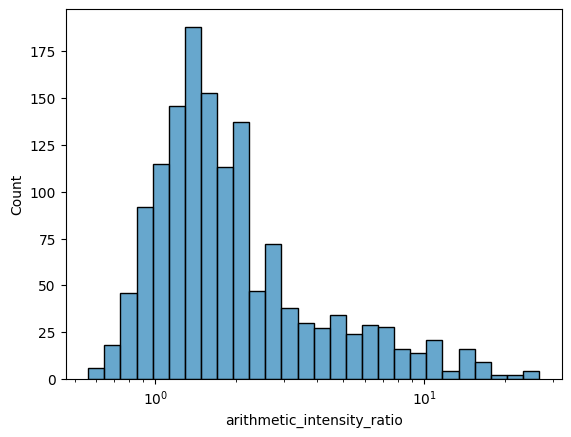

In [96]:
ax = sns.histplot(new_df['arithmetic_intensity_ratio'], log_scale=True)

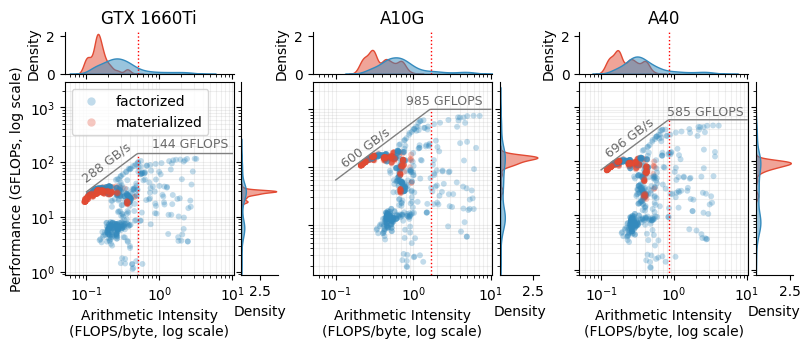

In [106]:
y_lim_max_flops = with_gpu_chars["gflops_per_second"].max()
# from https://towardsdatascience.com/a-guide-to-matplotlib-subfigures-for-creating-complex-multi-panel-figures-70fa8f6c38a4
figure = plt.figure(figsize=(8, 3))
figs = figure.subfigures(1, 3)
figs = figs.flatten()
axes_list = []
prev_ax_joint = None
prev_ax_marg_x = None
y_lim_max_flops = with_gpu_chars["gflops_per_second"].max()
annot_locs = {
    "1660": (10**-0.1, 2**7.5),
    "a10g": (10**-0.1, 2**10.2),
    "a40":(10**-0.1, 10**2.85)
}
gpu_names = {
    "1660": "GTX 1660Ti",
    "a10g": "A10G",
    "a40": "A40"
}


for i, (fig, (name, group)) in enumerate(zip(figs, with_gpu_chars.groupby("gpu"))):
    # This parameter defines the size ratio between the main plot and the margin plots
    ratio = 4

    # Defining a gridspec where the subplots are places
    gs = plt.GridSpec(ratio + 1, ratio + 1)
    # The main scatterplot
    ax_joint = fig.add_subplot(gs[1:, :-1], sharey=prev_ax_joint)
    # prev_ax_joint = ax_joint
    # The margin plots are sharing an axis with the main plot
    ax_marg_x = fig.add_subplot(gs[0, :-1], sharex=ax_joint, sharey=prev_ax_marg_x)
    prev_ax_marg_x = ax_marg_x
    ax_marg_y = fig.add_subplot(gs[1:, -1], sharey=ax_joint)
    # Axis labels and ticklabels for the margin plots are set to not visible
    # Since they are shared with the main plot,
    # removing them for the margin will also remove them from the main plot
    plt.setp(ax_marg_x.get_xticklabels(), visible=False)
    plt.setp(ax_marg_y.get_yticklabels(), visible=False)
    plt.setp(ax_marg_x.get_xticklabels(minor=True), visible=False)
    plt.setp(ax_marg_y.get_yticklabels(minor=True), visible=False)
    
    ax_marg_x.set_title(gpu_names[name])
    
    bandwidth = group["gpu_memory_bandwidth"].iloc[0]
    max_flops = group["gpu_processing_power_double_precision"].iloc[0] * 1e3
    xs = np.logspace(-1, 1, 100)
    ys = [min(bandwidth * x, max_flops) for x in xs]

    ax_joint.plot(xs, ys, color="grey", linewidth=1)
    idx = ys.index(max_flops)
    line_kwargs = dict(color='red', linestyle='dotted', linewidth=1)
    ax_marg_x.axvline(xs[idx], **line_kwargs)
    
    ax_joint.annotate(
        f"{bandwidth} GB/s",
        xy=[xs[0] + (0 if i ==0 else 0.03), ys[0]**1.12],
        fontsize=9,
        rotation=37,
        rotation_mode="anchor",
        color="dimgray",
    )
    ax_joint.annotate(
        f"{max_flops :.0f} GFLOPS",
        xy=annot_locs[name],
        fontsize=9,
        color="dimgray",
    )

    sns.scatterplot(
        data=group,
        x="arithmetic_intensity",
        y="gflops_per_second",
        hue="type",
        ax=ax_joint,
        alpha=0.3,
        size=1,
        linewidth=0,
    )
    
    ax_joint.grid(which='both', alpha=0.20)
    ax_joint.set_axisbelow(True)
    ax_joint.set_yscale("log", base=10)
    ax_joint.set_xscale("log", base=10)
    ax_joint.set_ylim(top=y_lim_max_flops**1.2)
    ax_joint.set_ylabel("Performance (GFLOPs, log scale)")
    ax_joint.set_xlabel("Arithmetic Intensity\n(FLOPS/byte, log scale)")
    
    x_vals = ["arithmetic_intensity", "gflops_per_second"]
    axes = [ax_marg_x, ax_marg_y]
    arguments = [
        {"x": 'arithmetic_intensity', 'ax':ax_marg_x, 'log_scale':(10, False)},
        {"y": "gflops_per_second", 'ax':ax_marg_y, 'log_scale':(False, 10)}
    ]
    for kwargs in arguments:
        sns.kdeplot(
            data=group,
            hue="type",
            # kde=True,
            # stat="count",
            # bins=15,
            fill=True,
            alpha=0.5,
            legend=False,
            **kwargs
        )
    ax_joint.plot([xs[idx]]*2, [10**-1, max_flops], **line_kwargs)  # line separating compute bound and memory bound

    ax_marg_y.spines[['right', 'top']].set_visible(False)
    ax_marg_x.spines[['right', 'top']].set_visible(False)
    # ax_marg_y.grid(axis='y', which='major', alpha=0.3)
    # ax_marg_x.grid(axis='x', which='major', alpha=0.3) 
        
    handles, labels = ax_joint.get_legend_handles_labels()
    ax_joint.get_legend().remove()
    if i > 0:
        ax_joint.set_ylabel(None)
        ax_joint.set_yticklabels([])        
    if i == 0:
        ax_joint.legend(handles[:2], labels[:2], loc="upper left")
        
    ax_joint.set_xlim(10**-1.3, 10**1.02)
    ax_marg_y.set_xticks([2.5])
    ax_marg_y.set_xticklabels([2.5])
        
    axes_list.append([ax_joint, ax_marg_x, ax_marg_y])
    

    
figs[0].subplots_adjust(left=0.17, right=0.97, bottom=0.14, top=0.95)
figs[1].subplots_adjust(left=0.1, right=0.95)
figs[2].subplots_adjust(left=0.1, right=0.90)

figure.savefig("/home/pepijn/Documents/uni/y5/thesis/writing/overleaf/chapters/05_cost_estimation/figures/roofline-plot.pdf", bbox_inches='tight')


In [98]:
operator_map = {
       'Columnsummation': 'Column Summation',
       'ColumnsummationT': 'Column Summation Transpose',
       'LMM': 'LMM',
       'LMMT': 'LMM Transpose',
       'Leftmultiply': 'Left Multiply',
       'LeftmultiplyT': 'Left Multiply Transpose',
       'RMM': 'RMM',
       'RMMT': 'RMM Transpose',
       'Rightmultiply': 'Right Multiply',
       'RightmultiplyT': 'Right Multiply Transpose',
       'Rowsummation': 'Row Summation',
       'RowsummationT': 'Row Summation Transpose'
}

/tmp/ipykernel_65496/3754817531.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("operator"),
100%|██████████| 12/12 [01:30<00:00,  7.51s/it]


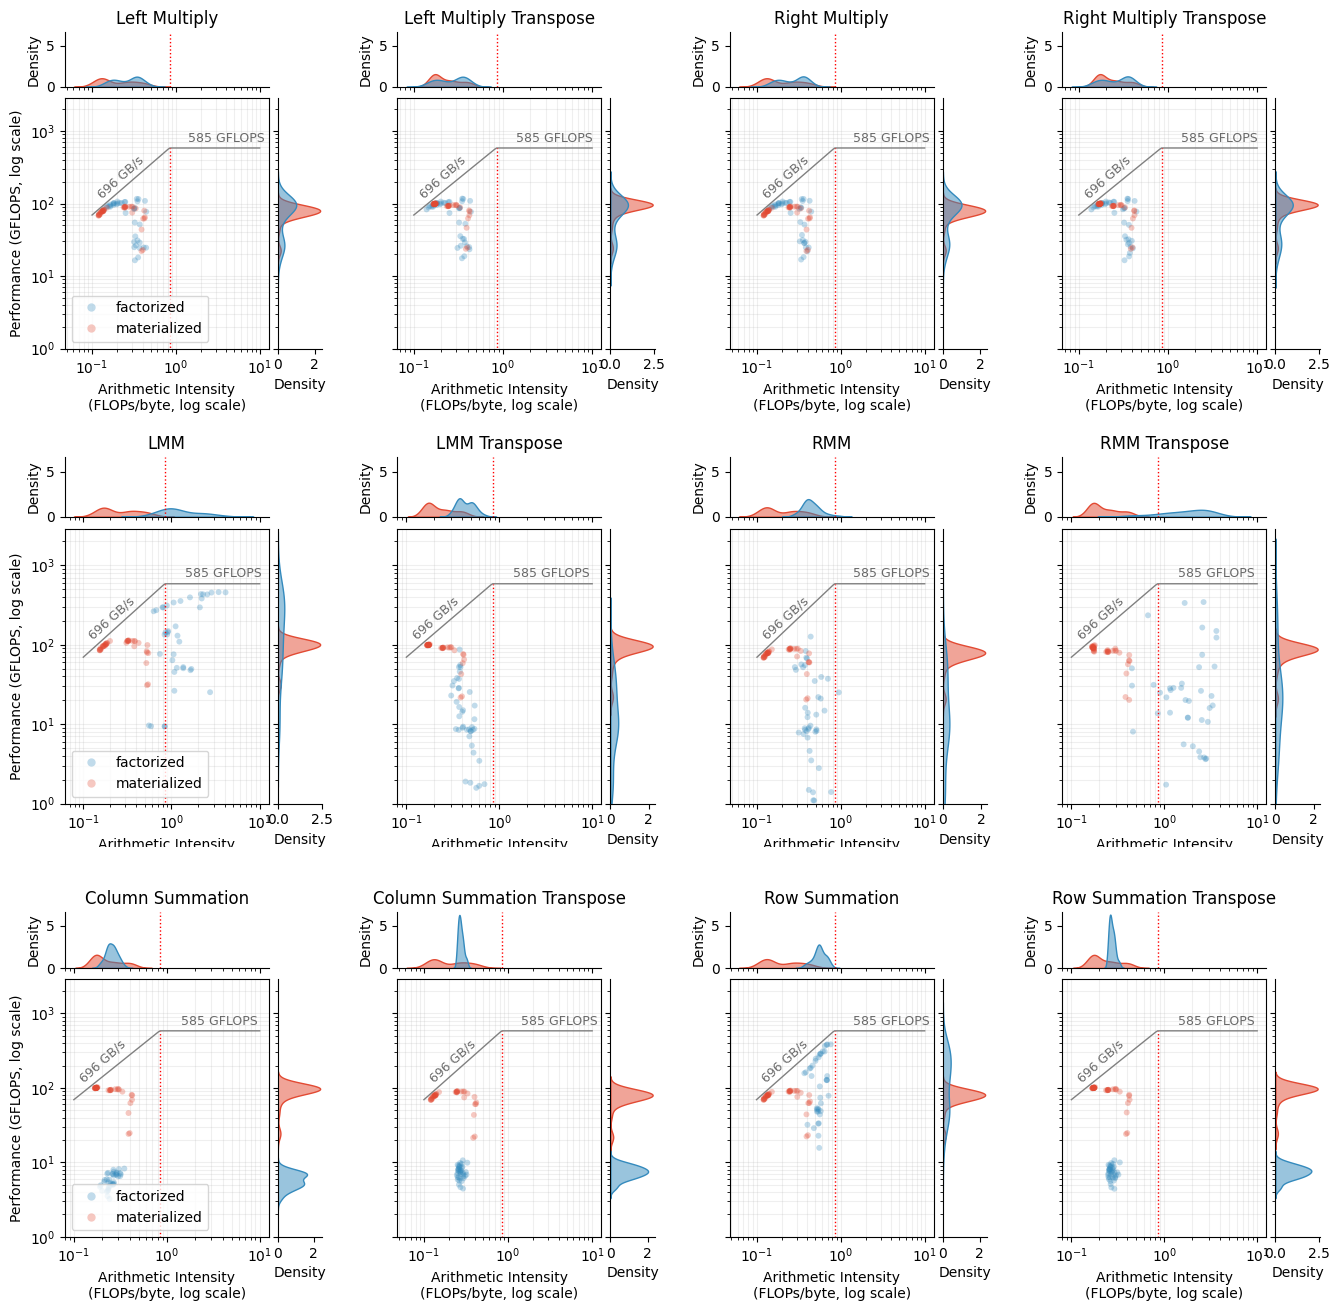

In [108]:

y_lim_max_flops = with_gpu_chars["gflops_per_second"].max()
# from https://towardsdatascience.com/a-guide-to-matplotlib-subfigures-for-creating-complex-multi-panel-figures-70fa8f6c38a4
rows = len(with_gpu_chars.operator.unique())
factor = 4
figure = plt.figure(figsize=(13.3, 4.5 * rows // factor))
figs = figure.subfigures(rows // factor, 4)
figs = figs.flatten()
axes_list = []
prev_ax_joint = None
prev_ax_marg_x = None
y_lim_max_flops = with_gpu_chars["gflops_per_second"].max()
annot_locs = {"1660": (10**0.1, 2**7.5), "a10g": (10**0.2, 2**10.2), "a40": (10**0.15, 10**2.85)}

with_gpu_chars['operator'] = pd.Categorical(with_gpu_chars['operator'], categories=['Leftmultiply', 'LeftmultiplyT', 'Rightmultiply', 'RightmultiplyT', 'LMM', 'LMMT', 'RMM', 'RMMT', 'Columnsummation', 'ColumnsummationT', 'Rowsummation', 'RowsummationT'], ordered=True)
for i, (fig, (type, group)) in tqdm(
    enumerate(
        zip(
            figs,
            with_gpu_chars[with_gpu_chars.gpu == "a40"]
            .sort_values('operator')
            .sort_values("type", ascending=True)
            .groupby("operator"),
        )
    ),
    total=rows,
):
    
    name = "a40"
    # This parameter defines the size ratio between the main plot and the margin plots
    ratio = 4

    # Defining a gridspec where the subplots are places
    gs = plt.GridSpec(ratio + 1, ratio + 1)
    # The main scatterplot
    ax_joint = fig.add_subplot(gs[1:, :-1], sharey=prev_ax_joint)
    # prev_ax_joint = ax_joint
    # The margin plots are sharing an axis with the main plot
    ax_marg_x = fig.add_subplot(gs[0, :-1], sharex=ax_joint, sharey=prev_ax_marg_x)
    prev_ax_marg_x = ax_marg_x
    ax_marg_y = fig.add_subplot(gs[1:, -1], sharey=ax_joint)
    # Axis labels and ticklabels for the margin plots are set to not visible
    # Since they are shared with the main plot,
    # removing them for the margin will also remove them from the main plot
    plt.setp(ax_marg_x.get_xticklabels(), visible=False)
    plt.setp(ax_marg_y.get_yticklabels(), visible=False)
    plt.setp(ax_marg_x.get_xticklabels(minor=True), visible=False)
    plt.setp(ax_marg_y.get_yticklabels(minor=True), visible=False)

    ax_marg_x.set_title(operator_map[type])

    bandwidth = group["gpu_memory_bandwidth"].iloc[0]
    max_flops = group["gpu_processing_power_double_precision"].iloc[0] * 1e3
    xs = np.logspace(-1, 1, 100)
    ys = [min(bandwidth * x, max_flops) for x in xs]

    ax_joint.plot(xs, ys, color="grey", linewidth=1)
    idx = ys.index(max_flops)
    line_kwargs = dict(color="red", linestyle="dotted", linewidth=1)
    ax_joint.plot([xs[idx]]*2, [10**-1, max_flops], **line_kwargs)  # line separating compute bound and memory bound
    
    ax_marg_x.axvline(xs[idx], **line_kwargs)

    ax_joint.annotate(
        f"{bandwidth} GB/s",
        xy=[xs[0] + 0.03, ys[0] ** 1.12],
        fontsize=9,
        rotation=42,
        rotation_mode="anchor",
        color="dimgray",
    )
    ax_joint.annotate(
        f"{max_flops :.0f} GFLOPS",
        xy=annot_locs[name],
        fontsize=9,
        color="dimgray",
    )

    sns.scatterplot(
        data=group,
        x="arithmetic_intensity",
        y="gflops_per_second",
        hue="type",
        ax=ax_joint,
        alpha=0.3,
        size=1,
        linewidth=0,
    )

    ax_joint.grid(which="both", alpha=0.20)
    ax_joint.set_axisbelow(True)
    ax_joint.set_yscale("log", base=10)
    ax_joint.set_xscale("log", base=10)
    ax_joint.set_ylim(top=y_lim_max_flops**1.2)
    ax_joint.set_ylabel("Performance (GFLOPS, log scale)")
    ax_joint.set_xlabel("Arithmetic Intensity\n(FLOPs/byte, log scale)")

    x_vals = ["arithmetic_intensity", "gflops_per_second"]
    axes = [ax_marg_x, ax_marg_y]
    arguments = [
        {"x": "arithmetic_intensity", "ax": ax_marg_x, "log_scale": (10, False)},
        {"y": "gflops_per_second", "ax": ax_marg_y, "log_scale": (False, 10)},
    ]
    for kwargs in arguments:
        sns.kdeplot(
            data=group,
            hue="type",
            # kde=True,
            # stat="count",
            # bins=15,
            fill=True,
            alpha=0.5,
            legend=False,
            **kwargs,
        )

    ax_marg_y.spines[["right", "top"]].set_visible(False)
    ax_marg_x.spines[["right", "top"]].set_visible(False)
    # ax_marg_y.grid(axis='y', which='major', alpha=0.3)
    # ax_marg_x.grid(axis='x', which='major', alpha=0.3)

    handles, labels = ax_joint.get_legend_handles_labels()
    ax_joint.get_legend().remove()
    if i % factor != 0:
        ax_joint.set_ylabel(None)
        ax_joint.set_yticklabels([])
    else:
        ...
        # prev_ax_joint = ax_joint
        # ax_marg_y.set_xticks([2.5])
        # ax_marg_y.set_xticklabels([2.5])
        ax_joint.legend(handles[:2], labels[:2], loc="lower left")

    # if i == 1:
    #     ax_marg_y.set_xticks([0, 400])
    #     ax_marg_y.set_xticklabels([0, 400])

    axes_list.append([ax_joint, ax_marg_x, ax_marg_y])

maxtop, minbottom = 0,1e9999

# Get the maximum and minimum ylims from the axes_list
for ax_joint, _, _ in axes_list:
    bottom, top = ax_joint.get_ylim()
    maxtop = max(maxtop, top)
    minbottom = min(minbottom, bottom)

for ax_joint, _, _ in axes_list:
    ax_joint.set_ylim(10**0, maxtop)
    
for i, fig in enumerate(figs):
    if i < 4:
        fig.subplots_adjust(bottom=0.15)
        ax_joint.set_ylabel(None)
    elif i < 8:
        fig.subplots_adjust(top=0.90, bottom =0.1)
        ax_joint.set_ylabel(None)
    else:
        fig.subplots_adjust(top=0.85)
figure.savefig(
    "/home/pepijn/Documents/uni/y5/thesis/writing/overleaf/appendices/figures/roofline-operators.pdf",
    bbox_inches="tight",
)

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:02<00:00,  1.04it/s]


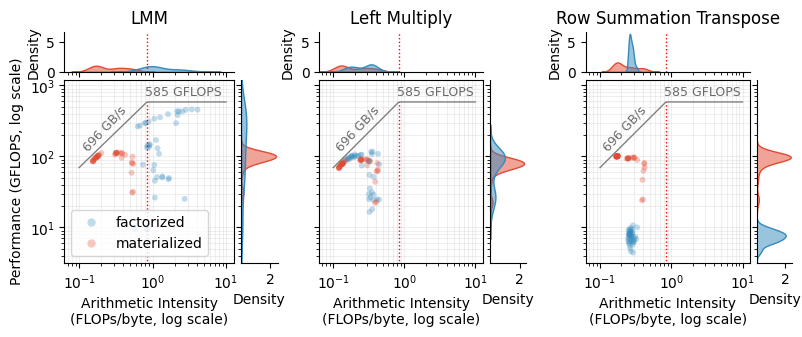

In [100]:
with_gpu_chars["gflops_per_second"] = with_gpu_chars["ops_per_second"] / 1e9
y_lim_max_flops = with_gpu_chars["gflops_per_second"].max()
# from https://towardsdatascience.com/a-guide-to-matplotlib-subfigures-for-creating-complex-multi-panel-figures-70fa8f6c38a4
rows = len(with_gpu_chars.operator.unique())
factor = 4
figure = plt.figure(figsize=(8, 3))
figs = figure.subfigures(1, 3)
figs = figs.flatten()
axes_list = []
prev_ax_joint = None
prev_ax_marg_x = None
y_lim_max_flops = with_gpu_chars["gflops_per_second"].max()
annot_locs = {"1660": (10**0.1, 2**7.5), "a10g": (10**0.2, 2**10.2), "a40": (10**-0.1, 10**2.85)}
operators = ["Leftmultiply", "LMM", "RowsummationT"]
for i, (fig, (type, group)) in tqdm(
    enumerate(
        zip(
            figs,
            with_gpu_chars[(with_gpu_chars.gpu == "a40") & (with_gpu_chars.operator.isin(operators))]
            .sort_values("type", ascending=True)
            .groupby(with_gpu_chars.operator.astype(object))
        )
    ),
    total=3,
):
    name = "a40"
    # This parameter defines the size ratio between the main plot and the margin plots
    ratio = 4

    # Defining a gridspec where the subplots are places
    gs = plt.GridSpec(ratio + 1, ratio + 1)
    # The main scatterplot
    ax_joint = fig.add_subplot(gs[1:, :-1], sharey=prev_ax_joint)
    # prev_ax_joint = ax_joint
    # The margin plots are sharing an axis with the main plot
    ax_marg_x = fig.add_subplot(gs[0, :-1], sharex=ax_joint, sharey=prev_ax_marg_x)
    prev_ax_marg_x = ax_marg_x
    ax_marg_y = fig.add_subplot(gs[1:, -1], sharey=ax_joint)
    # Axis labels and ticklabels for the margin plots are set to not visible
    # Since they are shared with the main plot,
    # removing them for the margin will also remove them from the main plot
    plt.setp(ax_marg_x.get_xticklabels(), visible=False)
    plt.setp(ax_marg_y.get_yticklabels(), visible=False)
    plt.setp(ax_marg_x.get_xticklabels(minor=True), visible=False)
    plt.setp(ax_marg_y.get_yticklabels(minor=True), visible=False)

    ax_marg_x.set_title(operator_map[type])

    bandwidth = group["gpu_memory_bandwidth"].iloc[0]
    max_flops = group["gpu_processing_power_double_precision"].iloc[0] * 1e3
    xs = np.logspace(-1, 1, 100)
    ys = [min(bandwidth * x, max_flops) for x in xs]

    ax_joint.plot(xs, ys, color="grey", linewidth=1)
    idx = ys.index(max_flops)
    line_kwargs = dict(color="red", linestyle="dotted", linewidth=1)
    ax_joint.plot([xs[idx]]*2, [10**-1, max_flops], **line_kwargs)  # line separating compute bound and memory bound

    ax_marg_x.axvline(xs[idx], **line_kwargs)

    ax_joint.annotate(
        f"{bandwidth} GB/s",
        xy=[xs[0] + 0.03, ys[0] ** 1.12],
        fontsize=9,
        rotation=47,
        rotation_mode="anchor",
        color="dimgray",
    )
    ax_joint.annotate(
        f"{max_flops :.0f} GFLOPS",
        xy=annot_locs[name],
        fontsize=9,
        color="dimgray",
    )

    sns.scatterplot(
        data=group,
        x="arithmetic_intensity",
        y="gflops_per_second",
        hue="type",
        ax=ax_joint,
        alpha=0.3,
        size=1,
        linewidth=0,
    )

    ax_joint.grid(which="both", alpha=0.20)
    ax_joint.set_axisbelow(True)
    ax_joint.set_yscale("log", base=10)
    ax_joint.set_xscale("log", base=10)
    ax_joint.set_ylim(top=y_lim_max_flops**1.2)
    ax_joint.set_ylabel("Performance (GFLOPS, log scale)")
    ax_joint.set_xlabel("Arithmetic Intensity\n(FLOPs/byte, log scale)")

    x_vals = ["arithmetic_intensity", "gflops_per_second"]
    axes = [ax_marg_x, ax_marg_y]
    arguments = [
        {"x": "arithmetic_intensity", "ax": ax_marg_x, "log_scale": (10, False)},
        {"y": "gflops_per_second", "ax": ax_marg_y, "log_scale": (False, 10)},
    ]
    for kwargs in arguments:
        sns.kdeplot(
            data=group,
            hue="type",
            # kde=True,
            # stat="count",
            # bins=15,
            fill=True,
            alpha=0.5,
            legend=False,
            **kwargs,
        )


    ax_marg_y.spines[["right", "top"]].set_visible(False)
    ax_marg_x.spines[["right", "top"]].set_visible(False)

    handles, labels = ax_joint.get_legend_handles_labels()
    ax_joint.get_legend().remove()
    if i != 0:
        ax_joint.set_ylabel(None)
        ax_joint.set_yticklabels([])
    else:
        ...
        # prev_ax_joint = ax_joint
        # ax_marg_y.set_xticks([2.5])
        # ax_marg_y.set_xticklabels([2.5])
        ax_joint.legend(handles[:2], labels[:2], loc="lower left")
    ax_joint.set_ylim(bottom=10**0.5)
    ax_joint.set_xlim(left=10**-1.2)

    ax_marg_y.set_xticks([2.])

    axes_list.append([ax_joint, ax_marg_x, ax_marg_y])

ylims = axes_list[2][0].get_ylim()
for ax_joint, _, _ in axes_list:
    ax_joint.set_ylim(ylims[0], 10**3.08)
figs[0].subplots_adjust(left=0.17, right=0.97)
figure.savefig(
    "/home/pepijn/Documents/uni/y5/thesis/writing/overleaf/chapters/05_cost_estimation/figures/roofline-operators.pdf",
    bbox_inches="tight",
)

Need: 
- compute time
- math time
- cost is max(compute time, math time)
- GPUs ops:bytes ratio

## Add calculated metrics

- dram_read = dram_bytes_read_sum
- dram_latency = ???
- dram_time = dram_read / memory_throughput_byte_weighted_mean
- l1 hitrate = l1_hit_rate_weighted_mean
- l1 latency = ???
- l1 bandwidth = 

l2 read = (1 - l2 hitrate) * dram_read

l2 read = (l1 miss * l1_read)

dram_read  = (l1 miss * l1_read) + (l2 miss * (l1 miss * l1_read))

l1_read = dram_read / (l2 miss * l1 miss + l1 miss)

- l1 amount read = 
- l2 hitrate = 
- l2 latency = 
- l2 bandwidth = 
- l2 amount read = 


from https://arxiv.org/pdf/1804.06826.pdf (V100)
 - L1 latency (cycles) 28
 - L2 latency (cycles) 193
 - DRAM latency


$$Teff = h1*t1 + (1-h1)*h2*t2 + (1-h1)*(1-h2)*t3$$
 - h1: l1_hit_rate_weighted_mean
 - t1 (micros): 30 cycles = 30 / gpu_clock_speed_base
 - h2: l2_hit_rate_weighted_mean
 - t2 (micros): 200 / gpu_clock_speed_base
 - t3: 600 / gpu_clock_speed_base

In [101]:
clock_speed_base = with_gpu_chars["gpu_clock_speed_base"]
l1_latency_ns = 30 / clock_speed_base * 1000
l2_latency_ns = 100 / clock_speed_base * 1000
dram_latency_ns = 600 / clock_speed_base * 1000
l1_hitrate = with_gpu_chars["l1_hit_rate_weighted_mean"]
l2_hitrate = (1 - l1_hitrate) * with_gpu_chars["l2_hit_rate_weighted_mean"]
dram_hitrate = (1 - l1_hitrate) * (1 - l2_hitrate)
with_gpu_chars["mem_time_eff_ns"] = (
    l1_hitrate * l1_latency_ns
    + l2_hitrate * l2_latency_ns
    + dram_hitrate * dram_latency_ns
)
with_gpu_chars['mem_cost_test'] = ((with_gpu_chars["mem_time_eff_ns"] + with_gpu_chars["dram_bytes_read_sum"]) / 1e9 / with_gpu_chars["mem_cost_seconds"])
with_gpu_chars.groupby("gpu")['mem_cost_test'].describe()

,count,mean,std,min,25%,50%,75%,max
gpu,,,,,,,,
1660,954.0,87.573567,47.267291,1.436142,43.005516,103.474232,126.678572,175.653588
a10g,954.0,174.054609,116.646496,1.288929,51.929184,195.357066,276.570264,462.453652
a40,954.0,194.221355,135.003641,1.086725,54.589647,211.953359,316.695351,508.853798


In [102]:
with_gpu_chars['calc_l2_read_sum'] =((1 - with_gpu_chars.l2_hit_rate_weighted_mean ) * with_gpu_chars.dram_bytes_read_sum)
with_gpu_chars['calc_l1_read_sum'] =((1 - with_gpu_chars.l1_hit_rate_weighted_mean ) * with_gpu_chars.calc_l2_read_sum)

In [103]:
with_gpu_chars[['dram_bytes_read_sum', 'l2_hit_rate_weighted_mean', 'calc_l2_read_sum', 'calc_l1_read_sum']]

,dram_bytes_read_sum,l2_hit_rate_weighted_mean,calc_l2_read_sum,calc_l1_read_sum
0,8.365440e+06,1.000000,0.000000e+00,0.000000e+00
1,7.561504e+06,1.000000,0.000000e+00,0.000000e+00
2,8.498912e+06,1.000000,0.000000e+00,0.000000e+00
3,8.561120e+06,1.000000,0.000000e+00,0.000000e+00
4,8.195616e+06,1.000000,0.000000e+00,0.000000e+00
...,...,...,...,...
3320,1.154509e+08,1.000000,0.000000e+00,0.000000e+00
3321,1.154484e+08,1.000000,0.000000e+00,0.000000e+00
3322,1.225429e+09,1.000000,0.000000e+00,0.000000e+00
3323,1.903227e+10,0.994407,1.064488e+08,3.382599e+07


In [104]:
tranpose = with_gpu_chars[with_gpu_chars.gpu == 'a10g'].head().T

In [105]:
def cache_cost(df):
    

SyntaxError: incomplete input (413028377.py, line 2)

In [ ]:
aggregated_df['cache_cost'] = aggregated_df['l1_hit_rate_weighted_mean'] * aggregated_df['l1_throughput_weighted_mean'] + aggregated_df['l2_hit_rate_weighted_mean'] * aggregated_df['l2_throughput_weighted_mean']

operator         type          gpu   dataset                                                                                                                                        
Columnsummation  factorized    1660  --mnt--data--100k--n_R=1-r_T=100000-c_T=10-rho_c_S=0.1-rho_c_R=0.1-p=0.0-join=inner--ratio_9.5--data--_preset                                        504800.0
                                     --mnt--data--100k--n_R=1-r_T=100000-c_T=10-rho_c_S=0.1-rho_c_R=0.1-p=0.0-join=left-t_R=0.6--ratio_8.5--data--_preset                                 428416.0
                                     --mnt--data--100k--n_R=1-r_T=100000-c_T=10-rho_c_S=0.1-rho_c_R=0.1-p=0.1-join=outer-t_R=0.7-rho_r_S=0.9--ratio_5.0--data--_preset                    659552.0
                                     --mnt--data--100k--n_R=1-r_T=100000-c_T=10-rho_c_S=0.1-rho_c_R=0.1-p=0.1-join=outer-t_R=0.9-rho_r_S=1.0--ratio_7.5--data--_preset                    496352.0
                                     --

In [ ]:
testdf.groupby(['operator', 'type', 'gpu', 'dataset']).apply(lambda x: weighted_mean(x['duration'], x['compute_throughput'])).head()

operator          type          gpu   dataset                                                                                                                         
ColumnsummationT  materialized  a10g  --mnt--data--1M--n_R=1-r_T=1000000-c_T=40-rho_c_S=0.1-rho_c_R=0.1-p=0.1-join=outer-t_R=0.7-rho_r_S=0.9--ratio_5.0--data--_preset    13.746692
LMM               factorized    a10g  --mnt--data--1M--n_R=1-r_T=1000000-c_T=30-rho_c_S=0.3-rho_c_R=0.3-p=0.1-join=outer-t_R=0.2-rho_r_S=1.0--ratio_1.0--data--_preset    72.314885
dtype: float64

operator
ColumnsummationT    Axes(0.125,0.11;0.775x0.77)
LMM                 Axes(0.125,0.11;0.775x0.77)
dtype: object

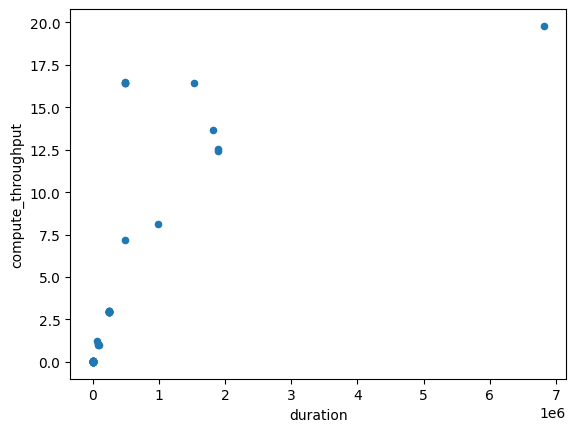

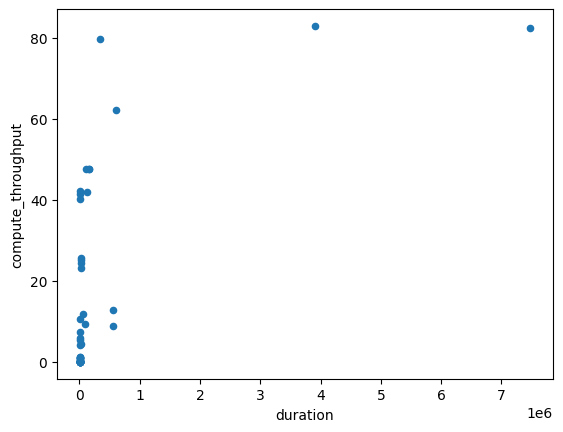

In [ ]:
testdf.groupby('operator').plot(x='duration', y='compute_throughput', kind='scatter', )

In [ ]:
testdf = df.head(100).copy()
testdf['sm_freq_compute'] = testdf["sm_active_cycles"] / testdf["duration"]
testdf[['sm_freq_compute', 'sm_frequency']]

metric,sm_freq_compute,sm_frequency
0,0.004430,7.960060e+08
1,0.003669,8.843304e+08
2,0.006038,8.595938e+08
3,0.096859,1.126200e+09
4,0.990490,1.132612e+09
...,...,...
47,1.309943,1.316059e+09
48,0.836680,1.219399e+09
49,1.311582,1.323093e+09
50,0.855133,1.243248e+09


/tmp/ipykernel_81919/1349319077.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  sumdf = df.groupby(['operator', 'type', 'gpu', 'dataset']).sum().reset_index(drop=False)


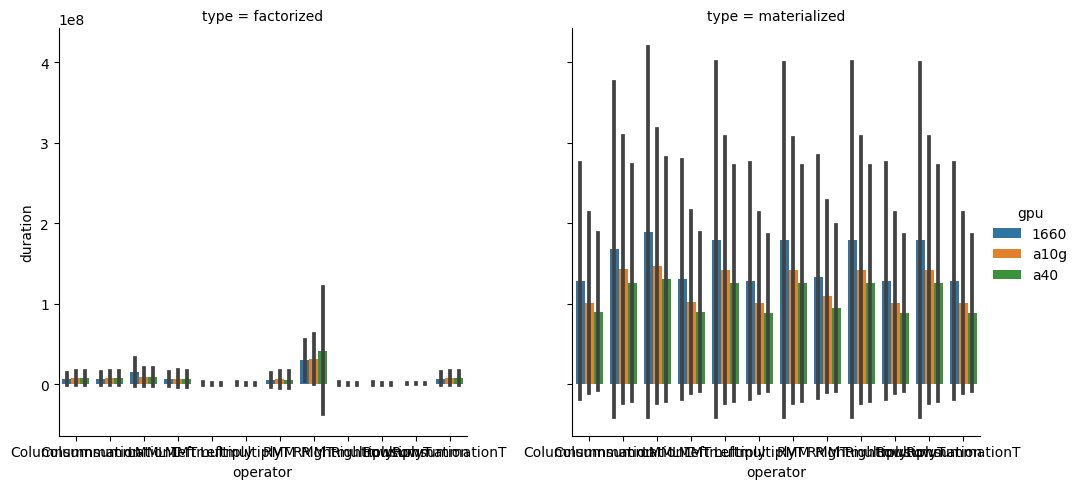

In [ ]:
sumdf = df.groupby(['operator', 'type', 'gpu', 'dataset']).sum().reset_index(drop=False)
sns.catplot(data=sumdf, x='operator', y='duration', hue='gpu', col='type', kind='bar', ci='sd')